# PV monitoring optimizer

This document contains the description for the PV portfolio optimizer. In the first stage, this optimizer will clasify the PV systems within a PV portfolio into 3 main categories:
 * **Green**: if the acumulated power losses of a PV system are not more than 50% of *1 day man-labor cost*.
 * **Orange**: if the acumulated power losses of a PV system are more than 50% and less than 100% of *1 day man-labor cost*.
 * **Red**: if the acummulated power losses of a PV system are equal or more than  *1 day man-labor cost*.

In this example *1 day man-labor cost* = 1000 CHF and *price per kWh* = 0.6296 CHF.
 
**NOTE**: The icons for this optimizer have been created with <a href="https://icons8.com/icons/set/solar-energy" target="_blank">this website</a>.

In [3]:
## for data
import numpy as np
import pandas as pd
## for plotting
import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")
%matplotlib notebook
## for geospatial
import folium
import geopy
## for clustering
from sklearn.cluster import KMeans

In [4]:
# Variables for the optimizer
one_day_cost = 1000  # chf
price_kwh = 0.6296  # price per kWh in chf

#Variables for the clustering
max_distance_btw_plats = 2  # km
max_days_to_fix = 1  # day

#icons taken from https://icons8.com/icons/set/solar-energy

In [5]:
# Plants list
import os
plants_df = pd.read_excel('optimizer.xlsx', 'Plant_list')
losses_df = pd.read_excel('optimizer.xlsx', 'Plant_losses', header=[0,1], index_col=0)
losses_df.index = pd.to_datetime(losses_df.index)
faults_df = pd.read_excel('optimizer.xlsx', 'Plant_faults', index_col=0)
faults_df.index = pd.to_datetime(faults_df.index)

## 1. Get initial location

The map will be started based on this initial location. In this case, we use Geneve as initial location city as follows:
***
` Get location to initialize the map
city = "Geneve"
get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print('Location:' location)
keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)`
***

In [6]:
# Get location to initialize the map
city = "Geneve"
## get location
locator = geopy.geocoders.Nominatim(user_agent="MyCoder")
location = locator.geocode(city)
print('Location:', location)
## keep latitude and longitude only
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Location: Genève, 1204, Schweiz/Suisse/Svizzera/Svizra
[lat, long]: [46.2017559, 6.1466014]


## 2. Cumulative losses

The accumulated losses for SIG PV plants portfolio looks as follows:

<IPython.core.display.Javascript object>


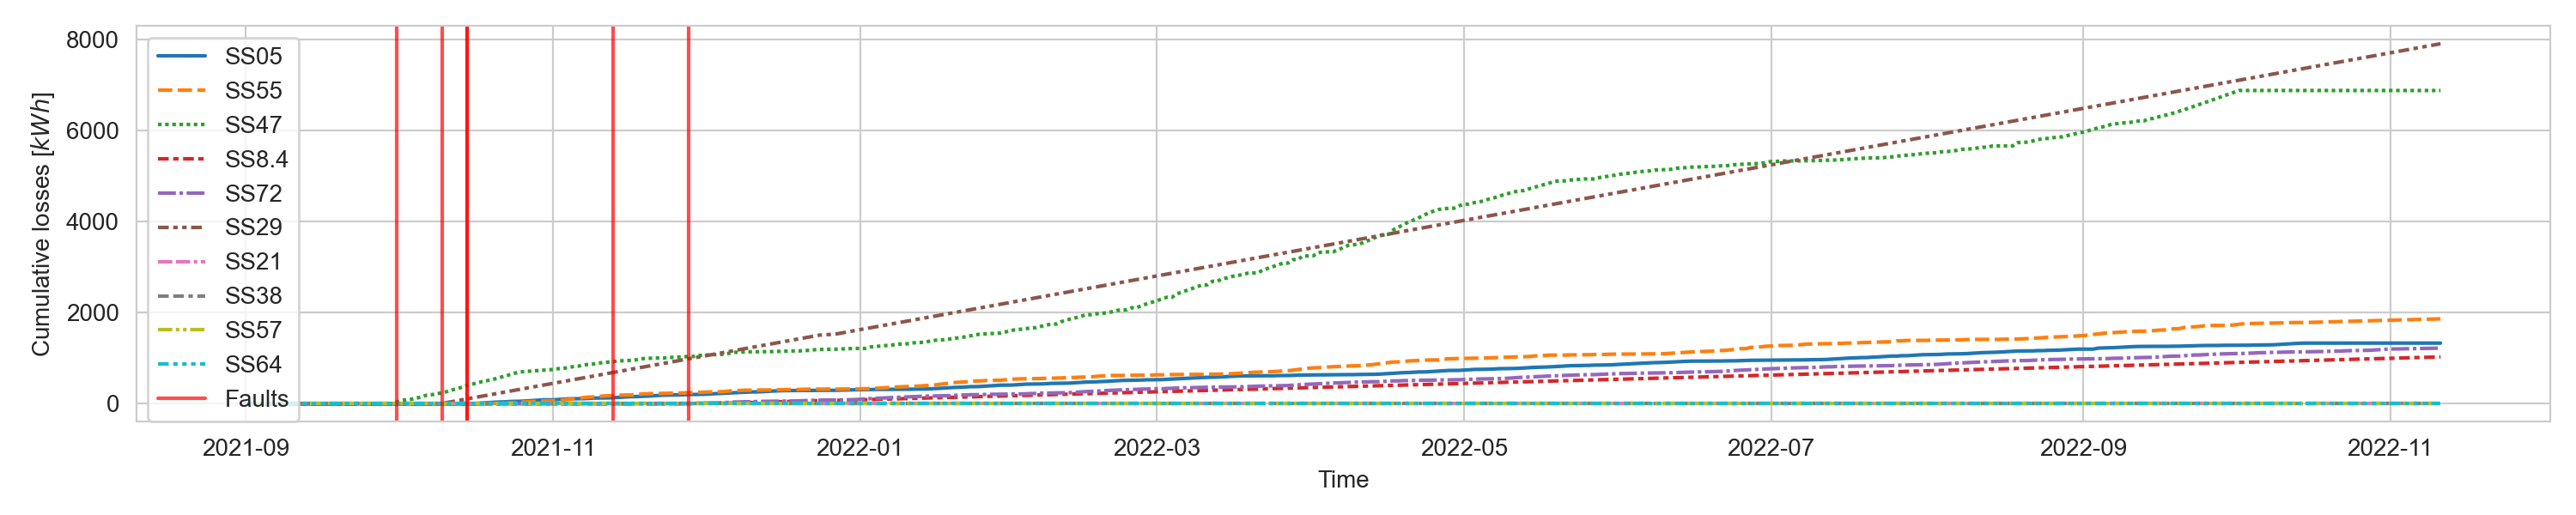

In [7]:
plt_losses = losses_df.iloc[:, losses_df.columns.get_level_values(1)=='Energy']
from matplotlib import rcParams

rcParams['figure.figsize'] = 15,3
ax= sns.lineplot(data=plt_losses)
i=0
for index, row in faults_df.iterrows():
    if i==0:
        label='Faults'
    else:
        label=''
    plt.axvline(index, 0,8000, alpha=0.7, color='red', label=label)
    i+=1
ax.set(xlabel='Time', ylabel='Cumulative losses [$kWh$]')
plt.legend(loc="upper left")
plt.tight_layout()

## 3. Interactive map

As mentioned before:
 * **Green**: if the acumulated power losses of a PV system are not more than 50% of *1 day man-labor cost*.
 <img src="ok_icon2.png"> 
 * **Orange**: if the acumulated power losses of a PV system are more than 50% and less than 100% of *1 day man-labor cost*.
 <img src="medium_icon2.png"> 
 * **Red**: if the acummulated power losses of a PV system are equal or more than  *1 day man-labor cost*.
 <img src="bad_icon2.png"> 

In [8]:
# create json for the interactive map
features = []

for _, row in plants_df.iterrows():
    name = row.Name
    lat = row.Latitude
    lon = row.Longitude
    df = losses_df[name]
    for i, row in df.iterrows():
        cost = row['Energy'] * price_kwh
        if pd.isna(row['Fault']):
            comments = 'Plant OK'
        else:
            comments = str(row['Fault'])
        if cost < (0.5 * one_day_cost):
            iconUrl = 'ok_icon2.png'
        elif (cost >= (0.5 * one_day_cost) and cost < one_day_cost):
            iconUrl = 'medium_icon2.png'
        else:
            iconUrl = 'bad_icon2.png' 
        popup = '<p><b>Name:</p></b> %s\n' %(name)
        popup += '<p><b>Comments:</p></b> %s\n' %(comments)
        popup += '<p><b>Cummulative costs:</p></b> %.2f' %(cost)
        # Create json features
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[lon, lat]},
            'properties': {
                'popup':popup,
                'icon':'marker',
                'iconstyle': {
                    'iconSize':[120, 120], # size of the icon
                    'iconUrl':iconUrl,},
                'time':str(i)}}
        features.append(feature)

In [12]:
from folium.plugins import TimestampedGeoJson

m=folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=12)

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': features},
    period='P1D',
    duration='P1D',
    auto_play=False,
    add_last_point=True,
    min_speed=0.5,
    max_speed=2,
    loop=False,
    loop_button=True,
    date_options='DD/MM/YYYY',
).add_to(m)
m

## 4. Clustering PV systems

The clustering of the PV systems is based on *K-Means* algorithm from `sklearn` library, with a twist. Basically what we do is the following:

 * K-Means clusters the PV systems based on the distance between them.
 * Once the clusters are calculated, we check for 2 different constrains:
     1. Total *'Time to fix'* of the entire cluster should not be more than 1 day.
     2. Total *'PV energy losses'* should be equivalent or higher than 1 *day man-labor cost*.

This cycle is repeated until the optimum number of clusters are defined. Same color circles indicate same cluster.

In [ ]:
#df_try = losses_df[losses_df.index == '2022-07-15']
# create json for the interactive map
clusters = []
# color for clusters
list_colors=['blue', 'gray', 'pink', 'yellow', 'brown', 'orange']
for index, row1 in losses_df.iterrows():
    df_k = pd.DataFrame()
    i = 0
    for _, row in plants_df.iterrows():
        name = row.Name
        df = row1[name]
        df_t = pd.DataFrame()
        df_t.at[i, 'Name'] = name
        df_t.at[i,'Lat'] = row.Latitude
        df_t.at[i,'Lon'] = row.Longitude
        df_t.at[i,'Losses_cost'] = float(df['Energy']) * price_kwh
        df_t.at[i,'Time_to_fix'] = float(df['Time_to_fix'])
        df_k = pd.concat([df_k, df_t])
        i+=1
    df_k.dropna(inplace=True)
    if (df_k.empty or len(df_k)<2):
        continue
    temp_cl = df_k.loc[(df_k.Losses_cost >= one_day_cost) & (df_k.Time_to_fix <= max_days_to_fix)]
    df_k = df_k[~(df_k['Name'].isin(temp_cl['Name']))]
    for k in range(2,10):
        if len(df_k) >= k:
            kmeans = KMeans(n_clusters = k, init ='random')
            kmeans.fit(df_k[df_k.columns[1:3]]) # Compute k-means clustering.
            df_k['cluster_label'] = kmeans.fit_predict(df_k[df_k.columns[1:3]])
            cost_df = pd.DataFrame(df_k.groupby(['cluster_label'])['Losses_cost'].sum()).reset_index()
            times_df = pd.DataFrame(df_k.groupby(['cluster_label'])['Time_to_fix'].sum()).reset_index()
            times_df = times_df[times_df['Time_to_fix'] <= max_days_to_fix]
            if times_df.empty:
                continue
            cost_df = cost_df.loc[cost_df['cluster_label'].isin(times_df['cluster_label'])]
            cost_df = cost_df.loc[cost_df['Losses_cost'] >= one_day_cost]
            if cost_df.empty:
                continue
            else:
                df_k = df_k.loc[df_k['cluster_label'].isin(cost_df['cluster_label'])]
                break
        else:
            df_k = pd.DataFrame()
            break
    if (df_k.empty & temp_cl.empty):
        continue
    if df_k.empty:
        max_cl = 0
        n = 0
    else:
        max_cl = df_k.cluster_label.max()
        n = 1
    for idx, row in temp_cl.iterrows():
        cluster = int(max_cl + n)
        temp_cl.at[idx, 'cluster_label'] = cluster
        n += 1
    df_k = pd.concat([temp_cl, df_k])
    # Create json features
    for _, row in df_k.iterrows():
        lon = row['Lon']
        lat = row['Lat']
        color = list_colors[int(row['cluster_label'])]
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[lon, lat]},
            'properties': {
                'icon':'circle',
                'iconstyle': {
                    'radius': 45, # size of the icon
                    'color':color,
                    'fillColor': color,
                    'weight': 1,
                    'opacity': 1,
                    'fillOpacity': 0.5},
                'time':str(index)}}
        clusters.append(feature)

In [ ]:
total_features = [*clusters, *features]

from folium.plugins import TimestampedGeoJson

m=folium.Map(location=location, tiles="cartodbpositron",
                  zoom_start=12)

TimestampedGeoJson(
    {'type': 'FeatureCollection', 'features': total_features},
    period='P1D',
    duration='P1D',
    auto_play=False,
    add_last_point=True,
    min_speed=0.5,
    max_speed=2,
    loop=False,
    loop_button=True,
    date_options='DD/MM/YYYY',
).add_to(m)
m